# Capstone Project

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fiankasy","key":"137359deb91c49c08acfd6b0e191be99"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset
!unzip stroke-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 208MB/s]
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.drop(['id', 'work_type'], axis=1, inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Rural,166.29,25.6,formerly smoked,0


### Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   Residence_type     5110 non-null   object 
 6   avg_glucose_level  5110 non-null   float64
 7   bmi                4909 non-null   float64
 8   smoking_status     5110 non-null   object 
 9   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 399.3+ KB


In [6]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    print(f"\n=== Fitur: {col} ===")
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(2)
    summary = pd.DataFrame({
        'count': vc,
        'percent (%)': pct
    })
    print(summary)


=== Fitur: gender ===
        count  percent (%)
gender                    
Female   2994        58.59
Male     2115        41.39
Other       1         0.02

=== Fitur: ever_married ===
              count  percent (%)
ever_married                    
Yes            3353        65.62
No             1757        34.38

=== Fitur: Residence_type ===
                count  percent (%)
Residence_type                    
Urban            2596         50.8
Rural            2514         49.2

=== Fitur: smoking_status ===
                 count  percent (%)
smoking_status                     
never smoked      1892        37.03
Unknown           1544        30.22
formerly smoked    885        17.32
smokes             789        15.44


In [8]:
df = df[df['gender'] != 'Other'].copy()

#### Handling Missing Value

In [9]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0
stroke,0


In [10]:
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(strategy='median')
df[['bmi']] = imp_median.fit_transform(df[['bmi']])

#### Handling Imbalance Dataset

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTENC

X = df.drop(columns='stroke')
y = df['stroke']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

print("Kolom kategorikal:", cat_cols)
print("Indeks kategorikal:", cat_indices)

smote_nc = SMOTENC(
    categorical_features=cat_indices,
    sampling_strategy=1.0,
    random_state=42
)
X_sm, y_sm = smote_nc.fit_resample(X, y)

print("Distribusi sebelum SMOTENC:", Counter(y))
print("Distribusi setelah SMOTENC:", Counter(y_sm))

df = pd.DataFrame(X_sm, columns=X.columns)

df['stroke'] = y_sm
df = df.reset_index(drop=True)

print("\nShape df:", df.shape)
display(df.head())

Kolom kategorikal: ['gender', 'ever_married', 'Residence_type', 'smoking_status']
Indeks kategorikal: [0, 4, 5, 8]
Distribusi sebelum SMOTENC: Counter({0: 4860, 1: 249})
Distribusi setelah SMOTENC: Counter({1: 4860, 0: 4860})

Shape df: (9720, 10)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1


### Exploratory Data Analysis

#### Univariate Analysis

In [12]:
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns.to_list()


Univariate summary for 'gender':
        jumlah sampel  persentase
gender                           
Female           5799        59.7
Male             3921        40.3


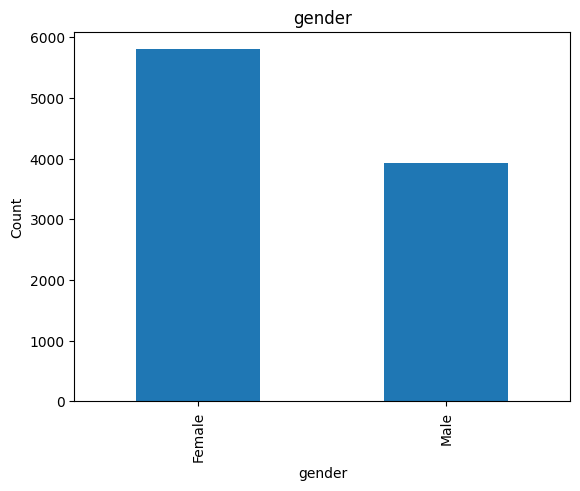


Univariate summary for 'ever_married':
              jumlah sampel  persentase
ever_married                           
Yes                    7874        81.0
No                     1846        19.0


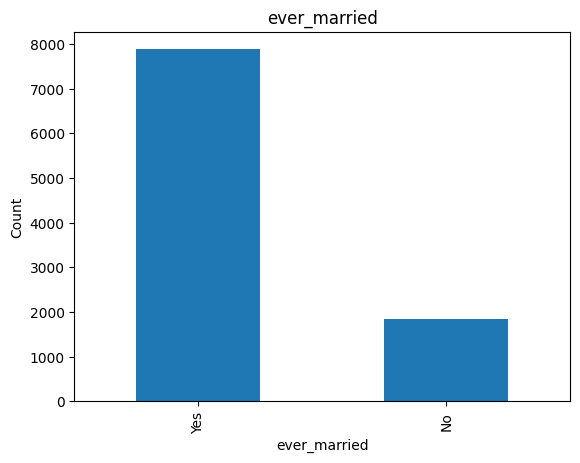


Univariate summary for 'Residence_type':
                jumlah sampel  persentase
Residence_type                           
Urban                    5282        54.3
Rural                    4438        45.7


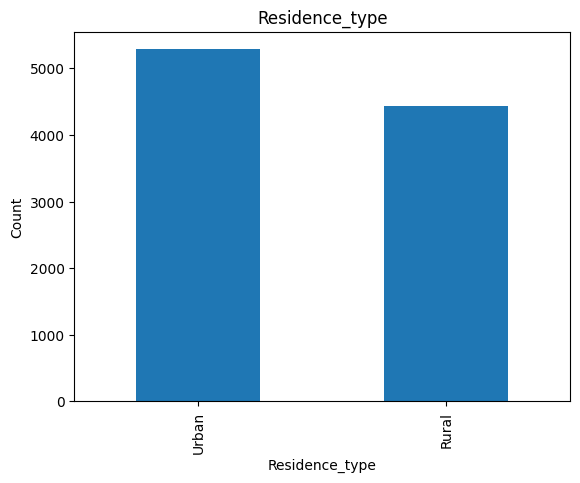


Univariate summary for 'smoking_status':
                 jumlah sampel  persentase
smoking_status                            
never smoked              3886        40.0
Unknown                   2218        22.8
formerly smoked           2208        22.7
smokes                    1408        14.5


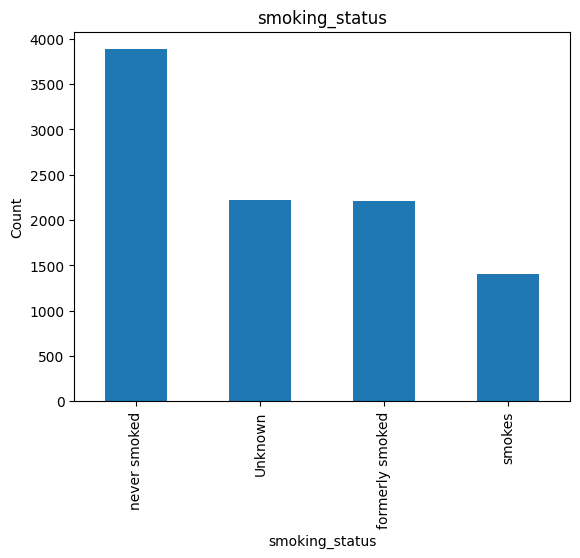

In [13]:
for feature in categorical_features:
    count = df[feature].value_counts()
    percent = 100 * df[feature].value_counts(normalize=True)

    summary_df = pd.DataFrame({
        'jumlah sampel': count,
        'persentase': percent.round(1)
    })
    print(f"\nUnivariate summary for '{feature}':")
    print(summary_df)

    count.plot(kind='bar', title=feature)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

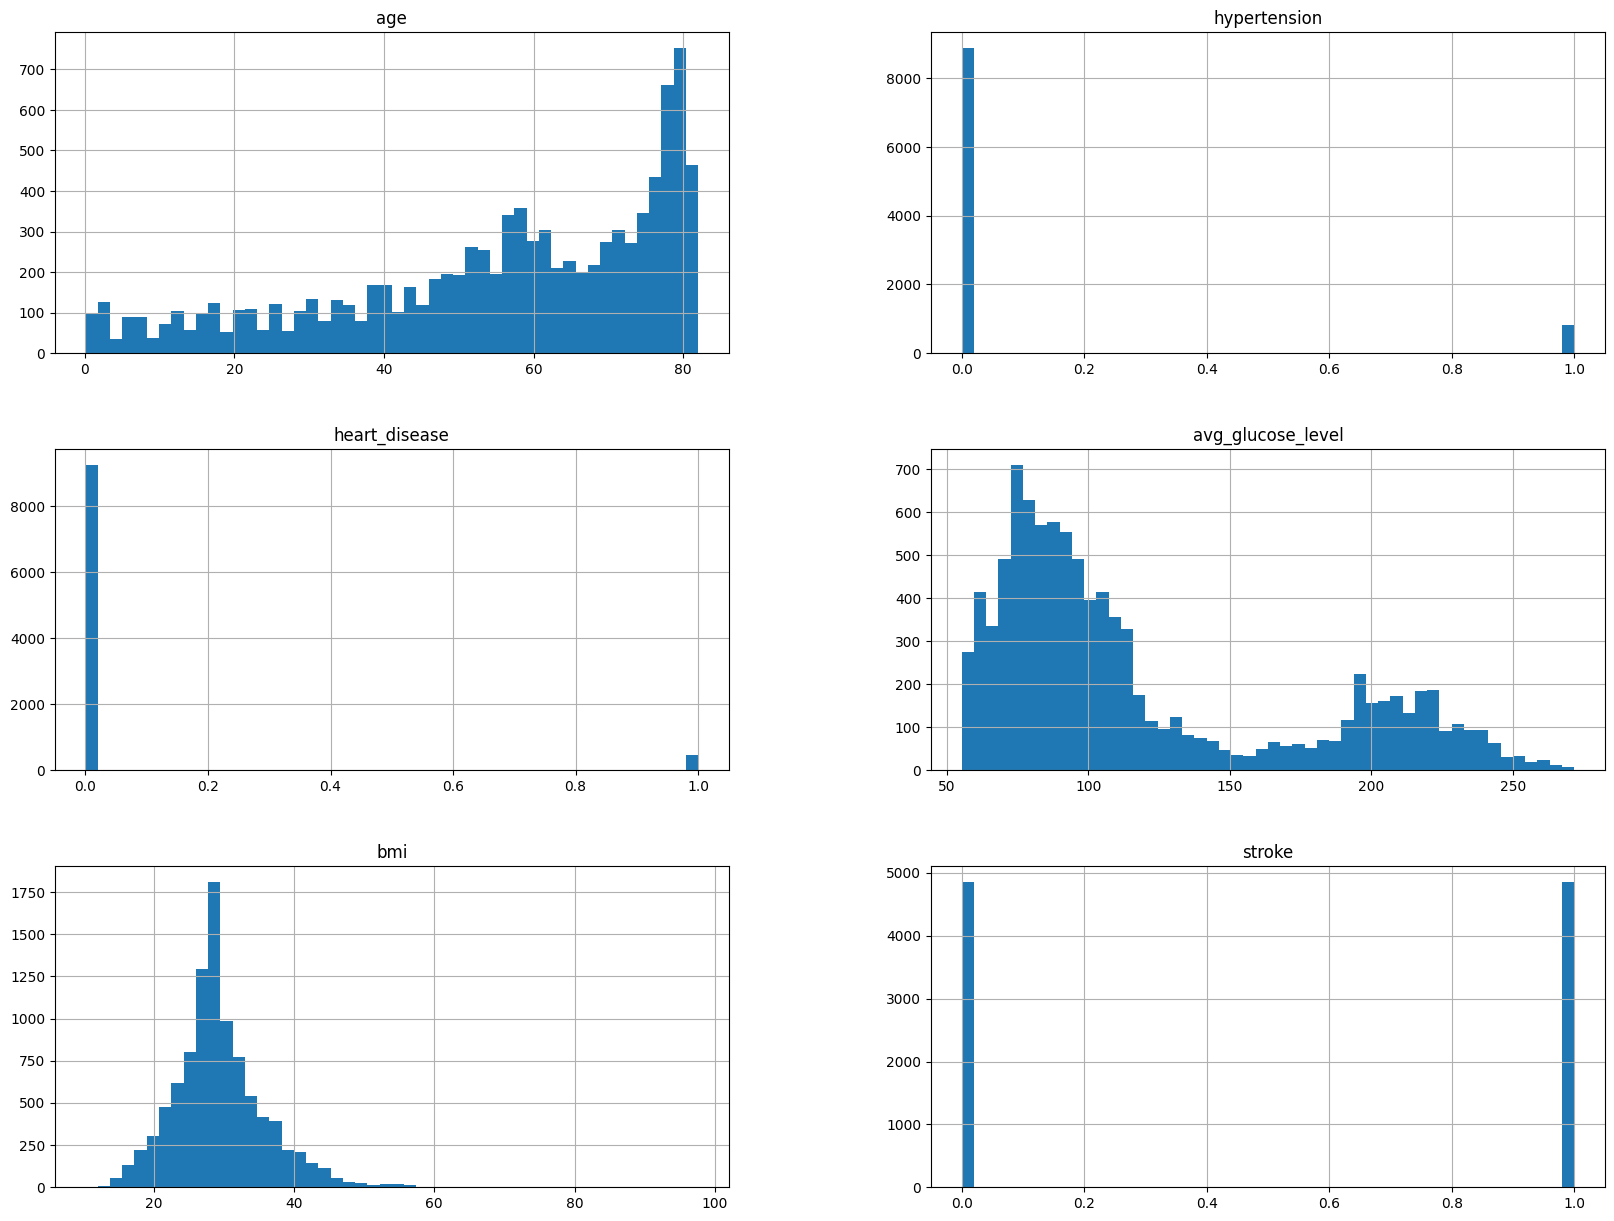

In [14]:
df.hist(bins=50, figsize=(20,15))
plt.show()

#### Multivariate Analysis

<ipython-input-15-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-15-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-15-aac79afcc83c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
<ipython-input-15-aac7

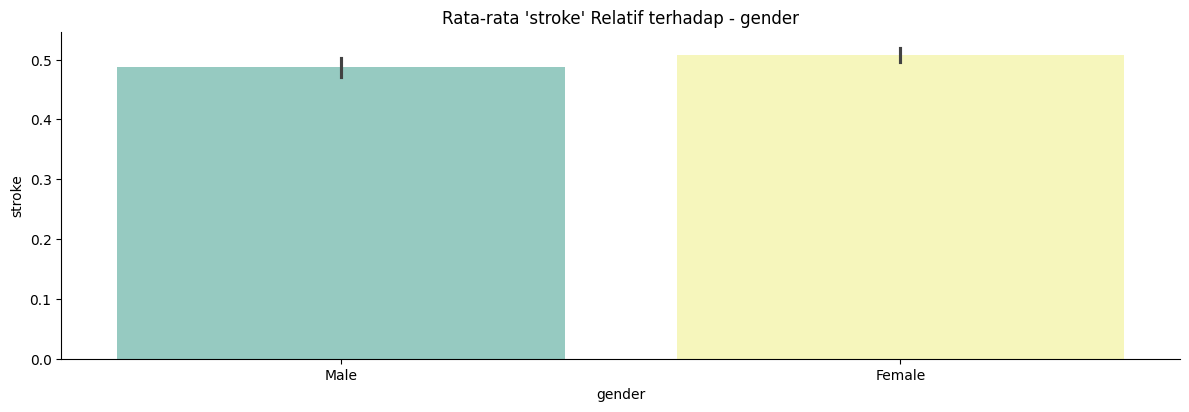

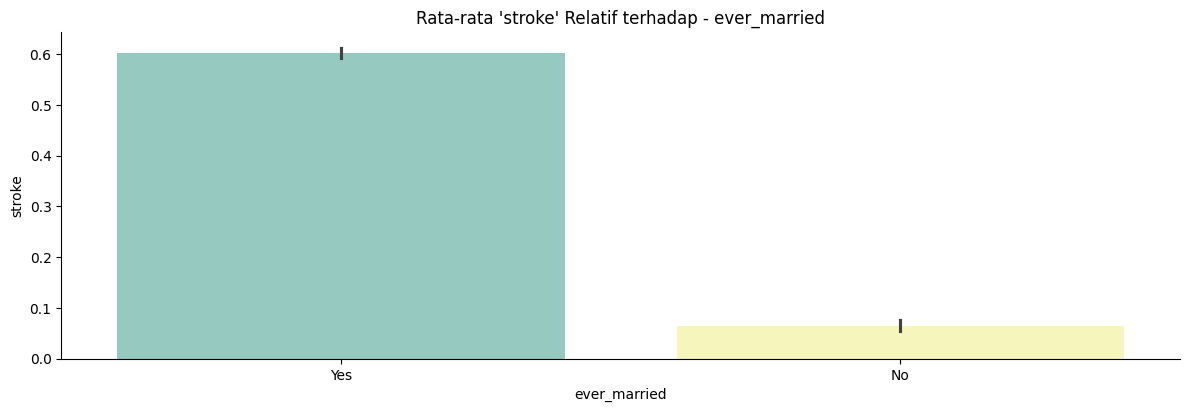

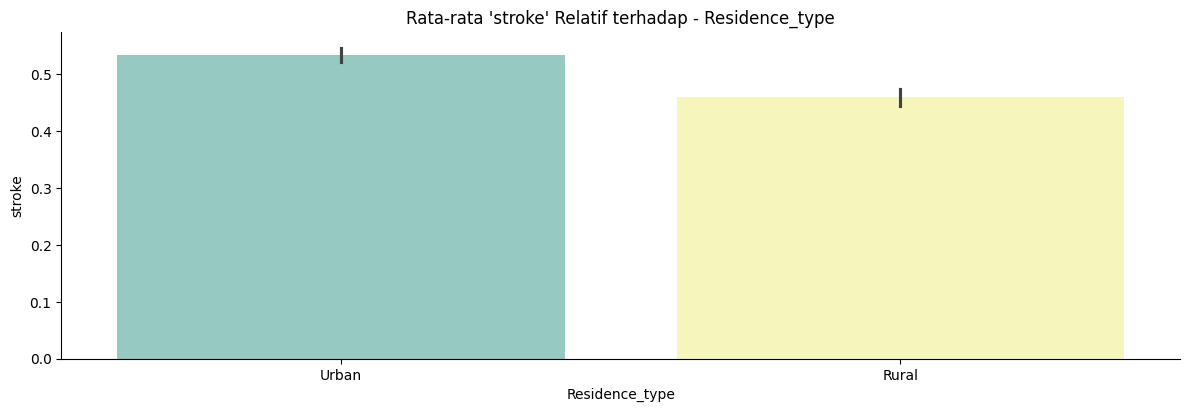

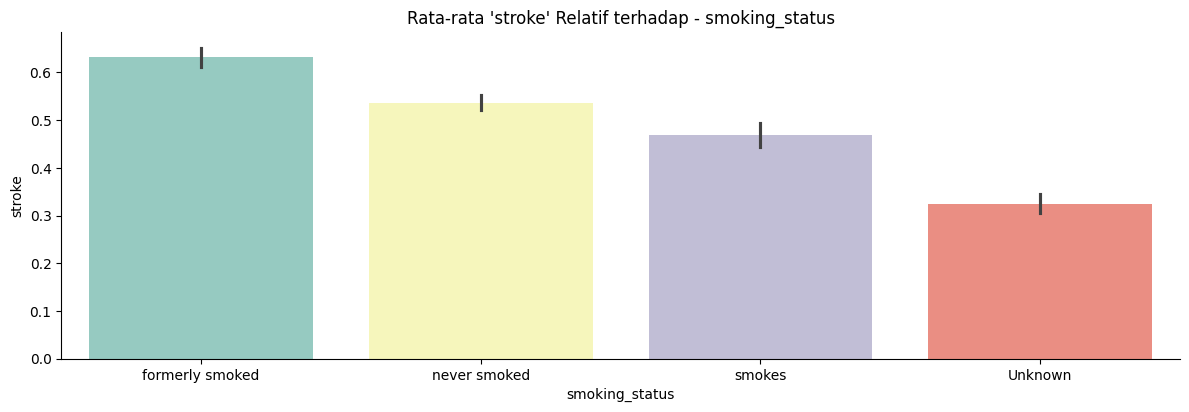

In [15]:
for col in categorical_features:
  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
  plt.title("Rata-rata 'stroke' Relatif terhadap - {}".format(col))

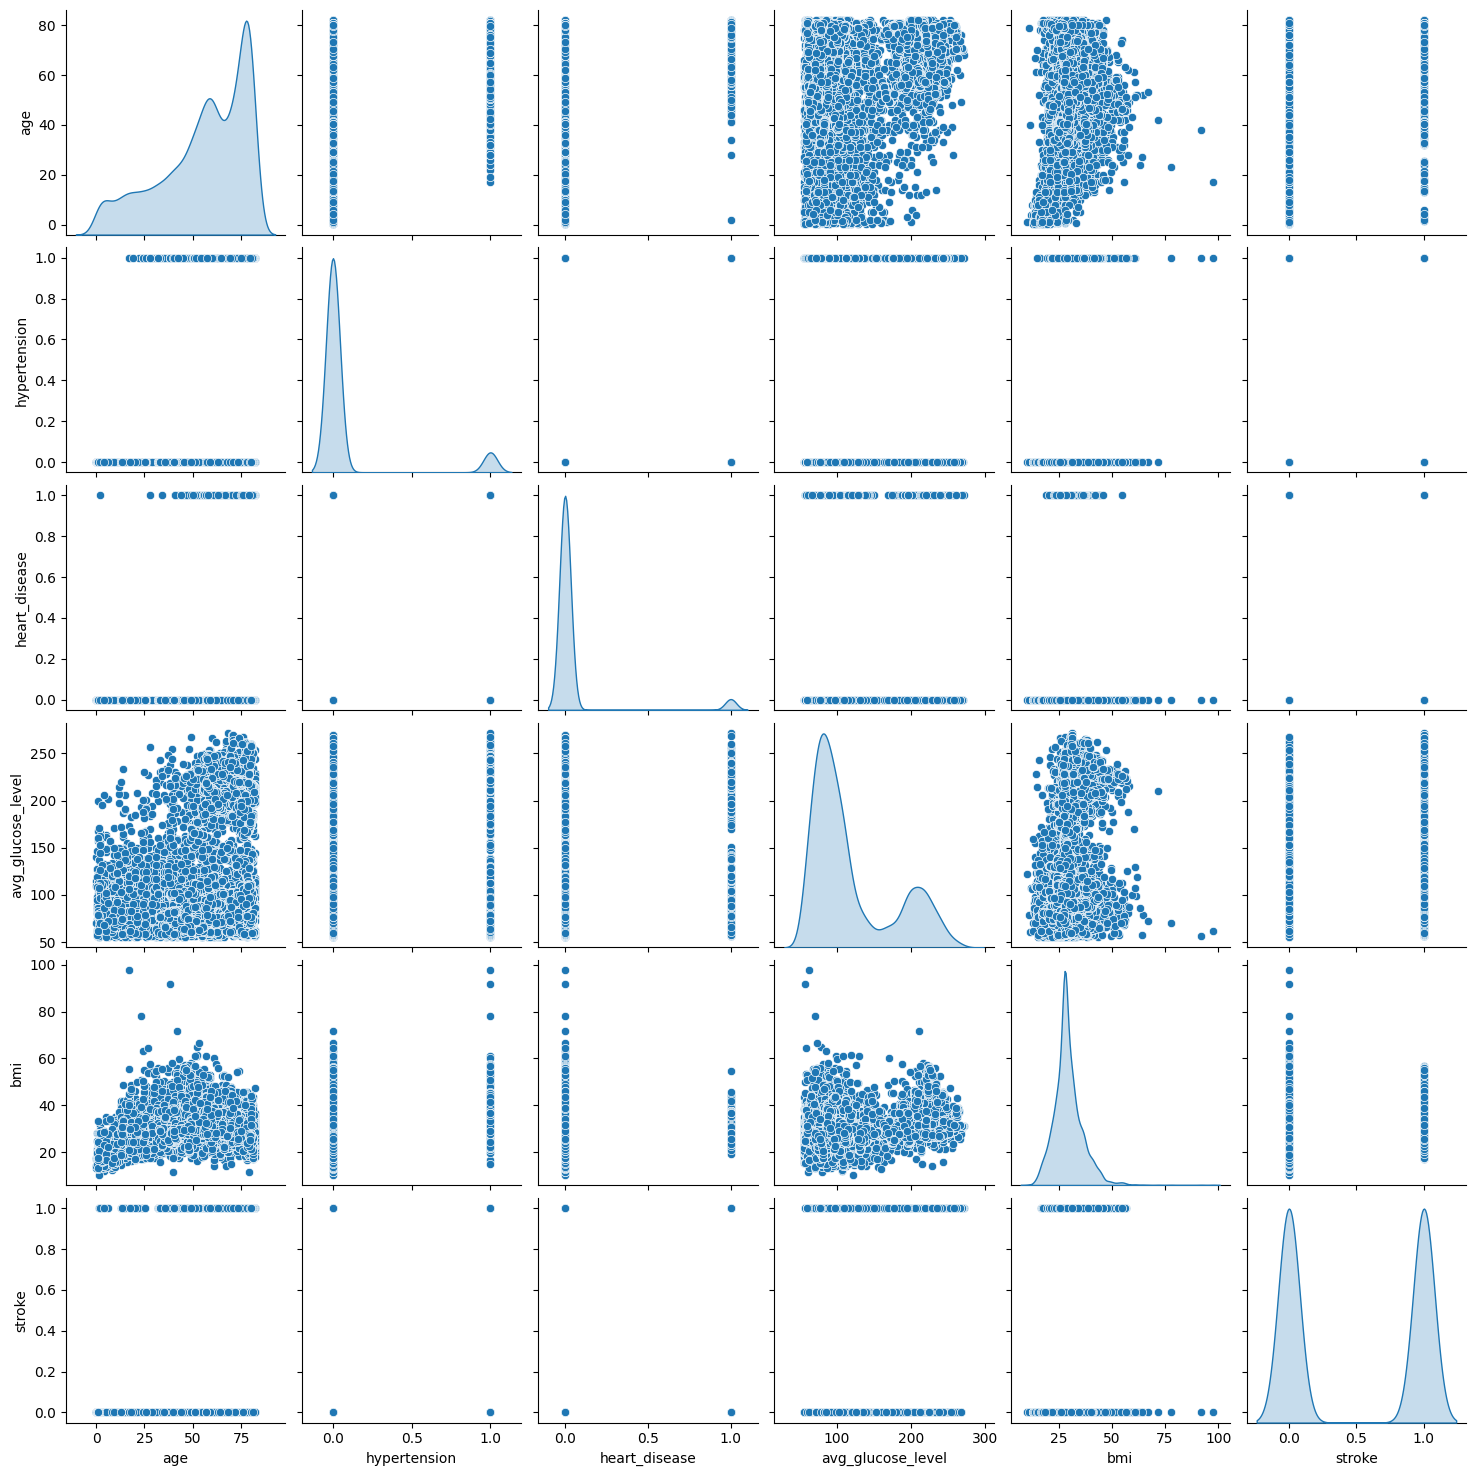

In [16]:
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

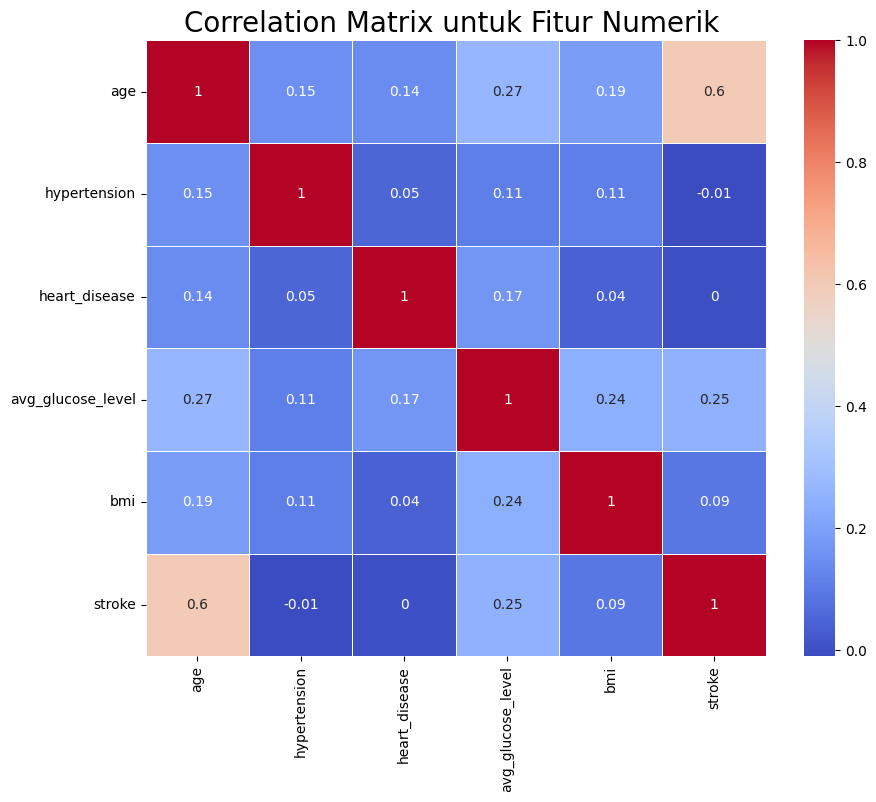

In [17]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

## Data Pre-Processing

In [18]:
df_encoded = pd.get_dummies(df, columns=categorical_features)
df_encoded

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.000000,0,1,228.690000,36.600000,1,False,True,False,True,False,True,False,True,False,False
1,61.000000,0,0,202.210000,28.100000,1,True,False,False,True,True,False,False,False,True,False
2,80.000000,0,1,105.920000,32.500000,1,False,True,False,True,True,False,False,False,True,False
3,49.000000,0,0,171.230000,34.400000,1,True,False,False,True,False,True,False,False,False,True
4,79.000000,1,0,174.120000,24.000000,1,True,False,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,77.957575,0,0,78.040889,23.976364,1,True,False,False,True,True,False,False,True,False,False
9716,79.617265,0,0,177.292744,25.080214,1,True,False,False,True,True,False,True,False,False,False
9717,70.609028,0,0,261.259578,38.934583,1,False,True,False,True,False,True,False,False,False,True
9718,80.000000,0,0,258.254341,31.461101,1,False,True,False,True,False,True,False,False,False,True


In [19]:
X = df_encoded.drop(columns='stroke')
y = df_encoded['stroke']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Total sample semua dataset: {len(X)}')
print(f'Total sample train dataset: {len(X_train)}')
print(f'Total sample test dataset: {len(X_test)}')

Total sample semua dataset: 9720
Total sample train dataset: 7776
Total sample test dataset: 1944


In [21]:
from sklearn.preprocessing import MinMaxScaler
# Standarisasi
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)